In [ ]:
window = 5

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch

class MyDataset(Dataset):
    def __init__(self, mode):
        if mode == 'train':
            dir = 'train.csv'
            self.data = pd.read_csv(dir, header=None)
        elif mode == 'test':
            dir = 'test.csv'
            self.data = pd.read_csv(dir, header=None)
        self.scale = 90
        self.res = []
        for i in range(len(self.data)):
            entry = self.data.iloc[i, :]
            for j in range(20 - window):
                x = list(entry[self.scale * j: self.scale * (j + window)])
                y = list(entry[self.scale * (j + 1): self.scale * (j + window + 1)])
                self.res.append((x, y))

    def __len__(self):
        return len(self.res)

    def __getitem__(self, index):
        return torch.tensor(self.res[index][0]).reshape(window, self.scale).cuda(), torch.tensor(self.res[index][1]).reshape(window, self.scale).cuda()


In [ ]:
dataset = MyDataset('train')
dataloader = DataLoader(dataset, batch_size=40, shuffle=True)
[x, y] = next(iter(dataloader))
print("input shape", x.shape)
print("gold shape", y.shape)

In [ ]:
from torch.nn import LSTM
from torch import nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.norm = torch.nn.LayerNorm(normalized_shape=(window, 90))
        self.fc1 = torch.nn.Linear(90, 512)
        self.fc2 = torch.nn.Linear(512, 90)
        self.lstm = LSTM(input_size=512, hidden_size=512, num_layers=1, batch_first=True)
    def forward(self, input):
        # input = self.norm(input)
        input = self.fc1(input)
        h0, c0 = torch.zeros(1, input.shape[0], input.shape[2]).cuda(), torch.zeros(1, input.shape[0], input.shape[2]).cuda()
        h, (hn, cn) = self.lstm(input, (h0, c0))
        h = self.fc2(h)
        return h

In [ ]:
from tqdm import tqdm

model = Model().cuda()
epoch = 10
tbar = tqdm(total=epoch * len(dataset))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))
for epoch_index in range(epoch):
    for batch_index, [sample, gold] in enumerate(iter(dataloader)):
        pred = model(sample)
        loss = torch.nn.functional.mse_loss(pred, gold)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tbar.set_postfix(loss=loss)
        tbar.update(sample.shape[0])
torch.save(model.state_dict(), 'params.pt')
tbar.close()

In [9]:
model = Model().cuda()
batch_size = 64
dataset = MyDataset('train')
dataloader = DataLoader(dataset, batch_size=batch_size)
tbar = tqdm(total=len(dataset))
model.load_state_dict(torch.load('params.pt'))
res = []
for batch_index, [sample, _] in enumerate(iter(dataloader)):
    pred = model(sample)[:, -1, :]
    res += pred.tolist()
    tbar.update(pred.shape[0])
pred_data = []
scale = 90
start_index = 0
for i in range(len(dataset.data)):
    entry = list(dataset.data.iloc[i, 0: scale * window])
    for j in range(20 - window):
        entry += res[start_index + j]
    start_index += 20 - window
    pred_data.append(entry)
pred_data = pd.DataFrame(pred_data)
pred_data.to_csv('pred_data_train.csv', index=None, header=None)
tbar.close()

100%|██████████| 102870/102870 [00:46<00:00, 2234.73it/s]


In [10]:
from matplotlib import pyplot as plt
import numpy as np
from random import randint

test_data_pred = pd.read_csv('pred_data_train.csv', header=None)
test_data_gold = pd.read_csv('train.csv', header=None)

1800
1800


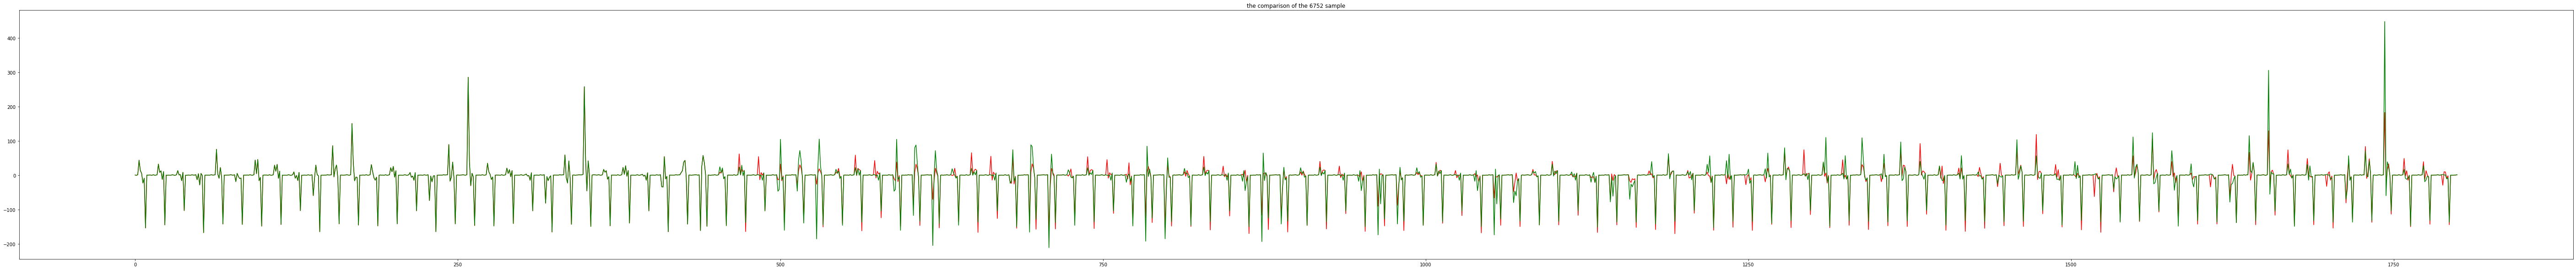

In [12]:
index = randint(0, len(dataset.data) - 1)
pred_curve = np.array(list(test_data_pred.iloc[index, :]))
gold_curve = np.array(list(test_data_gold.iloc[index, :]))
print(len(pred_curve))
plt.figure(figsize=(100, 10))
x = range(len(pred_curve))
print(len(x))
plt.plot(x, pred_curve, label='predict', c='r')
plt.plot(x, gold_curve, label='gold', c='g')
# plt.plot(x, np.abs(gold_curve-pred_curve), c='b')
plt.title('the comparison of the ' + str(index) + ' sample' )
plt.show()